In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
cd magic!!

/content/drive/MyDrive/magic!!


In [ ]:
import coco_text

In [ ]:
ct = coco_text.COCO_Text('COCO_Text.json')

loading annotations into memory...
0:00:03.807507
creating index...
index created!


In [ ]:
ct.info()

In [ ]:
imgs = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible'),('class','machine printed')])

In [ ]:
anns = ct.getAnnIds(imgIds=ct.val, 
                        catIds=[('legibility','legible'),('class','machine printed')], 
                        areaRng=[0,200])

In [ ]:
dataDir=r"2014train(text)"
dataType='train2014'

In [ ]:
%matplotlib inline
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
# get all images containing at least one instance of legible text
imgIds = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible')])
# pick one at random
img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

2014train(text)/COCO_train2014_000000307039.jpg


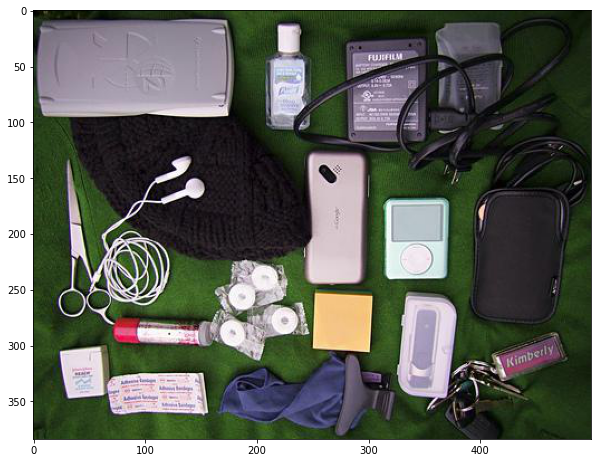

In [ ]:
path = '%s/%s'%(dataDir,img['file_name'])
I = io.imread(path)
print(path)
plt.figure()
plt.imshow(I)

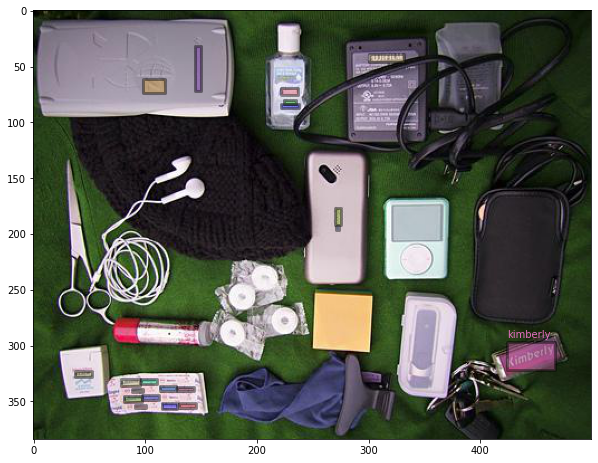

In [ ]:
# load and display text annotations
plt.imshow(I)
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns)

In [ ]:
len(imgIds)

13880

https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5


In [ ]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

In [ ]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        #self.coco = COCO(annotation)
        # self.ids = list(sorted(self.coco.imgs.keys()))

        self.coco = coco_text.COCO_Text('COCO_Text.json')
        imgIds = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible')])
        self.ids = list(sorted(imgIds))


    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        # ann_ids = coco.getAnnIds(imgIds=img_id)
        
        img = ct.loadImgs(img_id)[0]
        ann_ids = ct.getAnnIds(imgIds=img['id'])
        
        # Dictionary: target coco_annotation file for an image
        #coco_annotation = coco.loadAnns(ann_ids)
        
        coco_annotation = ct.loadAnns(ann_ids)

        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
# path to your own data and coco file
train_data_dir = '2014train(text)'
train_coco = 'COCO_Text.json'

# create own Dataset
my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          collate_fn=collate_fn)

loading annotations into memory...
0:00:12.263198
creating index...
index created!


In [ ]:
# select device (whether GPU or CPU)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

# DataLoader is iterable over Dataset
# for imgs, annotations in data_loader:
#     imgs = list(img.to(device) for img in imgs)
#     annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
#     print(annotations)


In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
# 2 classes; Only target class or background
num_classes = 2
num_epochs = 35
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)
len_dataloader

13880

In [ ]:
total_loss = []
for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        if i >= 1000:
          break
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        #print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        #print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

    # compute loss of this epoch
    total_loss.append(epoch_loss/1000)
    print(epoch_loss/1000)

tensor(0.8432, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7826, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8043, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7872, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7674, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7621, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7786, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7563, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7418, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7344, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7488, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7532, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7335, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7195, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6909, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7314, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7090, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6877, device='cuda:0', grad_fn=<DivBack

In [ ]:
torch.save( model.state_dict(), os.path.join('fasterRCNN_ep'+str(epoch)+'.pth') )
path = os.path.join('fasterRCNN_ep'+str(epoch)+'.pth')
base_model = torch.load(path)

In [ ]:
train_loss = []
for i in total_loss:
  train_loss.append(i.item())

list

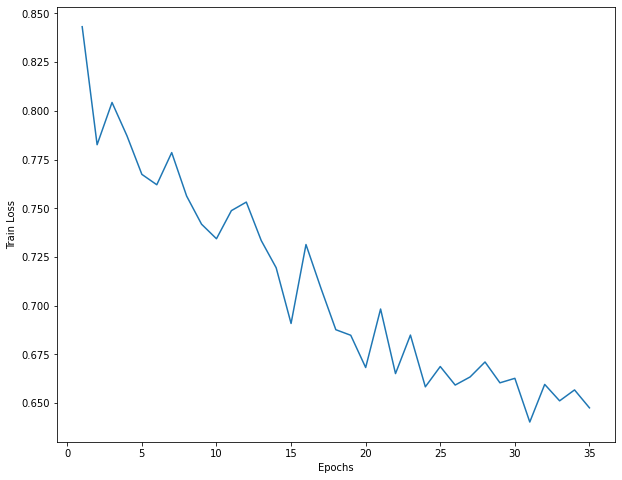

In [ ]:
base_x = np.linspace(1,35,35)
import matplotlib.pyplot as plt
plt.plot(base_x,train_loss)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.show()